In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scipy import stats

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)  

# Some styling
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import plotly.io as pio
pio.renderers.default = 'colab'
pio.templates.default = 'ggplot2'
%matplotlib inline

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data_link = 'https://raw.githubusercontent.com/elvanselvano/purwadhika-final-project/main/dataset/dev2.csv'
df = pd.read_csv(raw_data_link) #using dev set

In [3]:
df.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1748 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23061 09289,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1746 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23067 09289,38.914683,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1742 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23078 09288,38.914683,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,2,Hot Water Rad,Y,1.0,10,5,1913.0,NaN,1972,4.0,2010-02-26,1950000.0,Q,1,5344.0,1,4 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,1.0,4,11,2196,2018-07-22 18:01:43,Residential,NaN,NaN,1709 S STREET NW,WASHINGTON,DC,20009.0,18S UJ 23157 09248,38.914331,-77.039715,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,1,0,Warm Cool,Y,2.0,5,2,1917.0,1988.0,1957,2.0,2011-05-02,NaN,U,1,1260.0,1,2 Story,Row Inside,Above Average,Average,Common Brick,Metal- Sms,Hardwood,2.0,0,24,1261,2018-07-22 18:01:43,Residential,NaN,NaN,1769 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23042 09323,38.914983,-77.041055,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW


### 1. CASTING

In [4]:
#casting data types
def casting(df):
  df['NUM_UNITS'] = df['NUM_UNITS'].astype(pd.Int64Dtype())
  df['AYB'] = df['AYB'].astype(pd.Int64Dtype())
  df['LANDAREA'] = df['LANDAREA'].astype(float)
  df['KITCHENS'] = df['KITCHENS'].astype(pd.Int64Dtype())
  df['USECODE'] = df['USECODE'].astype(pd.Int64Dtype()).astype('category')
  df['ZIPCODE'] = df['ZIPCODE'].astype(pd.Int64Dtype()).astype('category')
  df['CMPLX_NUM'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
  df['CENSUS_TRACT'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
  df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])
  return df

In [5]:
df1 = casting(df)

In [6]:
def saleyear(df):
  df['SALEYEAR'] = df['SALEDATE'].dt.year
  return df

In [7]:
df2 = saleyear(df1)

### 2. QUALIFIED FEATURES 

The QUALIFIED feature is internally-used indicator to reflect if a sale is representative of market value according to the office's internal criteria. Since the 'U' means it does not reflect the market value, we will drop the 'U' value and QUALIFIED feature since it only contains 1 value of 'Q'.

In [8]:
def drop_qualified(df):
  df = df[df['QUALIFIED']=='Q']
  df = df.drop('QUALIFIED', axis=1)
  
  return df

In [9]:
df3 = drop_qualified(df2)

In [10]:
print('Before removing unqualified:', df2.shape)
print('After removing unqualified:', df3.shape)

Before removing unqualified: (105750, 49)
After removing unqualified: (60012, 48)


### 3. MISSING DATA

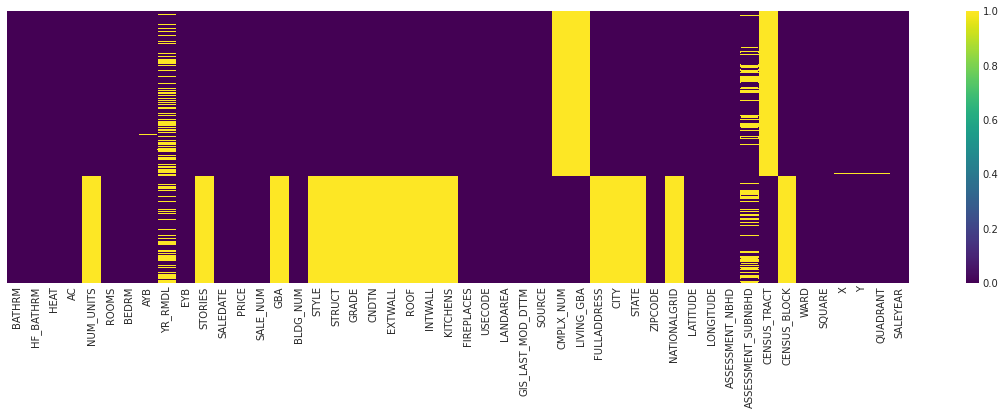

In [11]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df3.isnull(), yticklabels=False,cmap='viridis')
plt.show()

Since the missing values seems to have a pattern, we might want to dig deeper into the source (residential & condominium)

In [12]:
res = df3[df3['SOURCE']=='Residential']
con = df3[df3['SOURCE']=='Condominium']

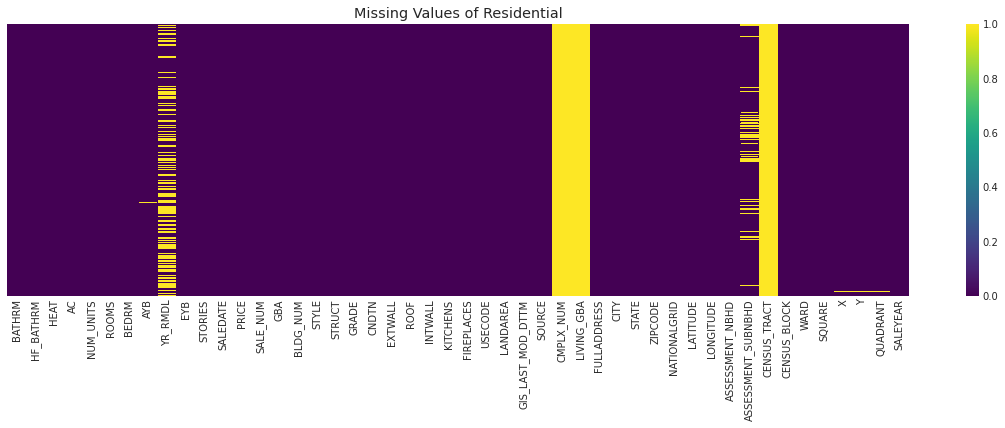

In [13]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(res.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

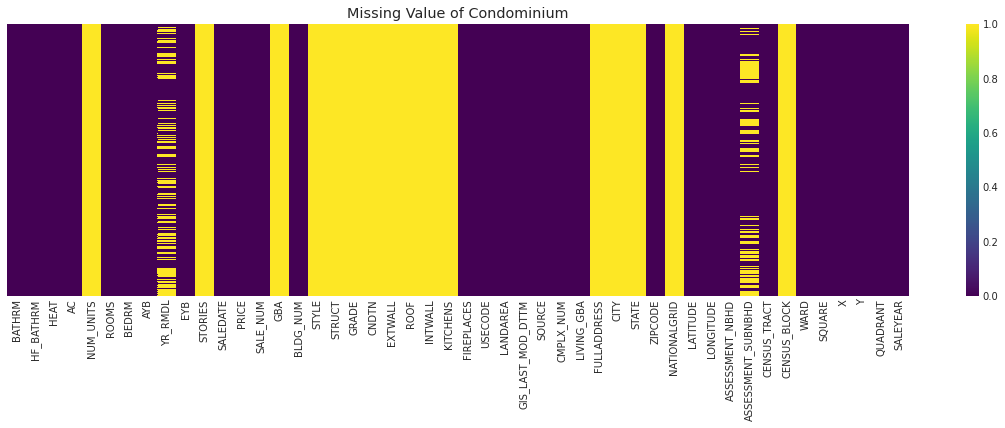

In [14]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(con.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Value of Condominium')
plt.show()

Clearly, they both have several different features. We assume that the price predictor model of residential and condominium will be different. The condominium data seems to have more missing value than the residential. In this case, we decide to build the price predictor of **residential**

In [15]:
def residential(df):
  df = df[df['SOURCE']=='Residential']
  
  return df

In [16]:
df4 = residential(df3)

In [17]:
df4.shape

(36500, 48)

Dropping unused features :
- CMPLX_NUM, LIVING_GBA, CENSUS_TRACT : only available in condominium data
- ASSESSMENT_SUBNBHD, FULLADDRESS,NATIONAL GRID, and CENSUS_BLOCK : high cardinality
- CITY, STATE : single value (Washington, DC)
- X, Y : same value with LONGITUDE and LATITUDE
- SALEDATE : replaced with SALEYEAR

In [18]:
def drop_unused_features(df):
    df = df.drop(['CMPLX_NUM','LIVING_GBA','CENSUS_TRACT','ASSESSMENT_SUBNBHD',
                   'FULLADDRESS','NATIONALGRID','CENSUS_BLOCK','CITY','STATE',
                   'X','Y','SALEDATE'],axis=1)
    return df

In [19]:
df5 = drop_unused_features(df4)

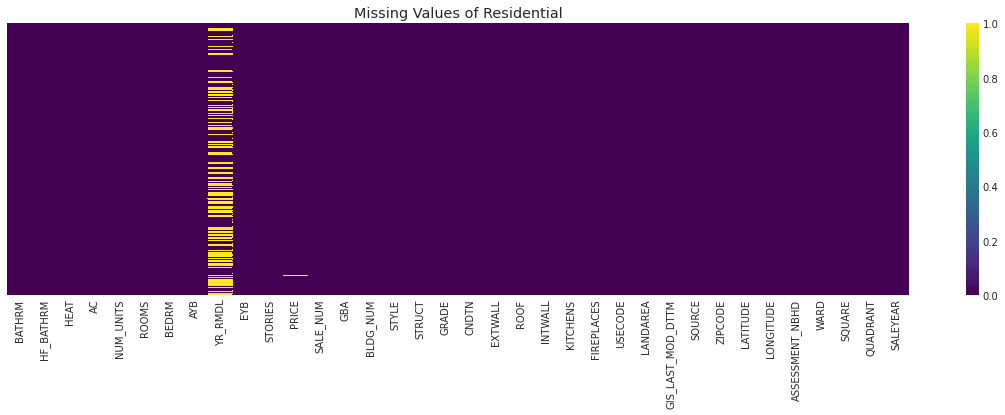

In [20]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df5.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

The YR_RMDL features seems too important to drop. Intuitively, whether the properties have been remodeled or not will affect the price. We decide to do feature engineering by converting the YR_RMDL into two other features. First is RMDL, which is a boolean (Y/N). Y means the property has been remodeled and vice versa.

In [21]:
#feature engineering YR_RMDL
def yr_rmdl(df):
    df['RMDL'] = np.where(df['YR_RMDL'].isna(),0,1)
    df = df.drop('YR_RMDL',axis=1)
    return df

In [22]:
df6 = yr_rmdl(df5)

In [23]:
df6.shape

(36500, 36)

In [24]:
#drop remaining missing values (price)
def drop_all(df):
  df = df.dropna()
  return df

In [25]:
df7 = drop_all(df6)

In [26]:
df7.shape

(36286, 36)

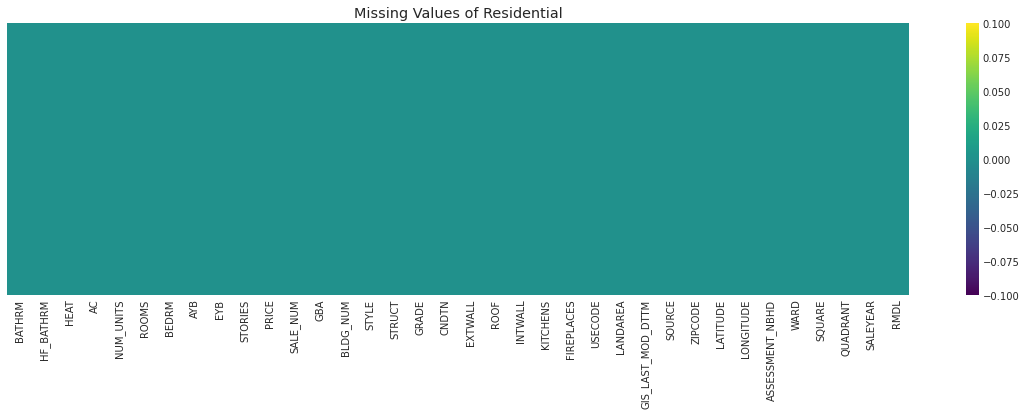

In [27]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df7.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

### 4. UNRELATED COLUMNS

some features do not related to the properties (update version date and source data)

In [28]:
def drop_unrelated_features(df):
    df = df.drop(['GIS_LAST_MOD_DTTM','SOURCE'],axis=1)
    return df

In [29]:
df8 = drop_unrelated_features(df7)

In [30]:
df8.shape

(36286, 34)

### 5. UNUSUAL VALUES

In [31]:
df8['AC'].value_counts() #checking unusual values of AC (0)

Y    27599
N     8680
0        7
Name: AC, dtype: int64

Convert AC to 1 and 0 (values of 0 is considered as N)

In [32]:
df8['HEAT'].value_counts() #checking unusual values of HEAT (No Data)

Forced Air        13676
Hot Water Rad     12342
Warm Cool          9510
Ht Pump             504
Water Base Brd       65
Elec Base Brd        46
Wall Furnace         43
Electric Rad         25
Gravity Furnac       23
Air-Oil              21
Evp Cool             10
Air Exchng            9
Ind Unit              6
No Data               6
Name: HEAT, dtype: int64

Since No Data of HEAT is considered small, we will drop the records containing it.

In [33]:
df8['ROOMS'].value_counts().sort_index() #checking unusual values of ROOMS (0)

0        13
2        11
3        75
4       710
5      3017
6     11419
7      7346
8      5755
9      2713
10     2313
11      860
12      999
13      253
14      176
15      108
16      388
17       19
18       45
19       11
20       43
21        3
22        2
23        1
24        3
25        2
26        1
Name: ROOMS, dtype: int64

We will drop properties with 0 room which is highly unlikely 

In [34]:
df8[df8['AYB'] > df8['SALEYEAR']].shape #checking unusual values of interaction between AYB & SALEYEAR

(139, 34)

We assume there is no sold properties before the properties has been built. Since these values is scarce, we will exclude the records

In [35]:
df8[df8['AYB'] > df8['EYB']].shape #checking unusual values of interaction between AYB & EYB

(8, 34)

Based on the Author explanation of the dataset, the EYB should be more recent than the AYB. We found 8 unusual values, which we will drop

In [36]:
df8.groupby('GRADE')['PRICE'].median().sort_values() #check price gradient of GRADE

GRADE
Low Quality       150000.0
Fair Quality      218000.0
Average           265000.0
Above Average     390000.0
Good Quality      669338.5
Very Good         840000.0
Excellent        1150000.0
Superior         1250000.0
Exceptional-A    2000000.0
Exceptional-B    3000000.0
Exceptional-C    5425000.0
Exceptional-D    5600000.0
Name: PRICE, dtype: float64

In [37]:
df8['GRADE'].value_counts() #check number of records for each GRADE category

Average          11145
Above Average    10815
Good Quality      7966
Very Good         3552
Excellent         1275
Superior          1015
Exceptional-A      319
Exceptional-B      117
Fair Quality        33
Exceptional-C       26
Exceptional-D       22
Low Quality          1
Name: GRADE, dtype: int64

Based on the price gradient for each GRADE, we can consider the exceptional grade as luxurious property. Since the price gap are quite high and the records are rare, we decide to limit our prediction model by excluding those in exceptional grade

In [38]:
#drop unusual values
def drop_unusual(df):
  df['AC'] = np.where(df['AC']=='Y',1,0) #convert to 1 0 
  df = df[df['HEAT']!='No Data'] #delete no data
  df = df[df['ROOMS']!=0] #exclude property with 0 rooms
  df = df[df['AYB']<= df['SALEYEAR']] #exclude values where AYB > SALEYEAR
  df = df[df['AYB']<= df['EYB']] #exclude values where AYB > EYB
  df = df[~df['GRADE'].isin(['Exceptional-D','Exceptional-C','Exceptional-B',
                             'Exceptional-A'])] #exclude exceptional GRADE

  return df

In [39]:
df9 = drop_unusual(df8)

In [40]:
df9.shape

(35667, 34)

### 6. SIMILAR VALUES

- STORIES has similar values with STYLE. We keep STYLE since STORIES has many outliers due to mistyping.

In [41]:
df9[['STORIES','STYLE']].value_counts()

STORIES  STYLE          
2.00     2 Story            26490
3.00     3 Story             3284
2.50     2.5 Story Fin       1872
1.00     1 Story             1038
1.50     1.5 Story Fin        536
                            ...  
2.50     1.5 Story Fin          1
2.30     2 Story                1
250.00   2.5 Story Fin          1
2.25     3.5 Story Fin          1
         3.5 Story Unfin        1
Length: 94, dtype: int64

In [42]:
def drop_similar_features(df):
    df = df.drop(['STORIES'], axis=1)
    
    return df

In [43]:
df10 = drop_similar_features(df9)

In [44]:
df10.shape

(35667, 33)

### 7. CORRELATION

CATEGORICAL (CRAMERS V)

In [45]:
from itertools import combinations
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

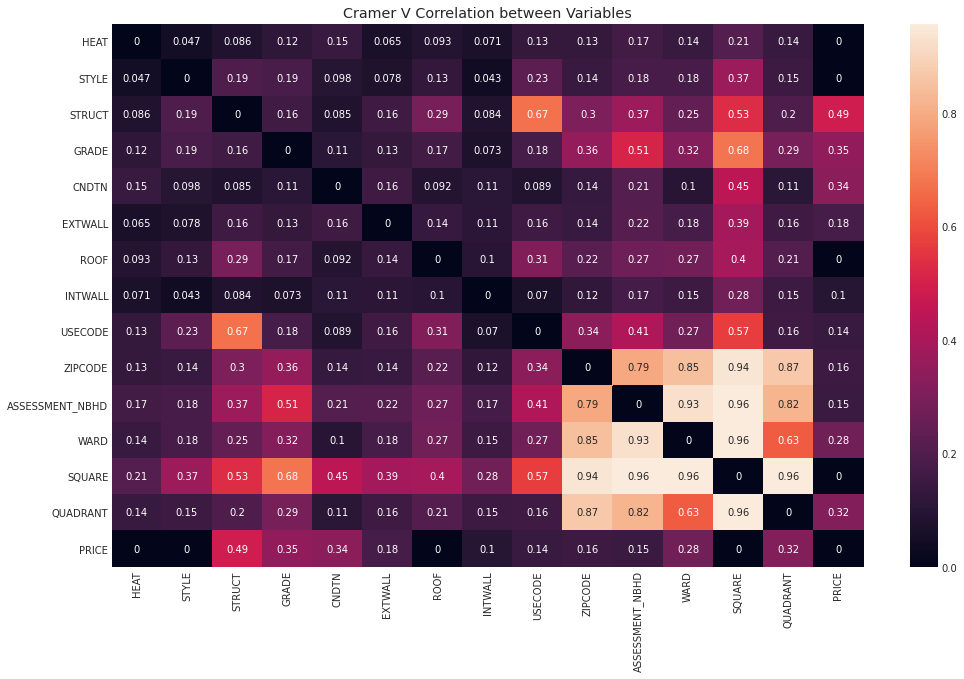

In [46]:
cols = ['HEAT','STYLE','STRUCT', 'GRADE', 'CNDTN', 'EXTWALL','ROOF', 'INTWALL','USECODE','ZIPCODE','ASSESSMENT_NBHD','WARD','SQUARE','QUADRANT','PRICE']
# fitur kategorikal yang diambil yang sekiranya dapat di korelasikan dengan 'Price', kategori geographical yang diambil hanya yang mempunyai distinct data yg kecil
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df10[col1], df10[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

The location features seems to have interaction with each other. Based on multiple trial on the model, we decide to take only WARD, since it is one of the top feature importance according to our model

We also want to drop LONGLAT since it is already represented by the WARD

In [47]:
df10.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'AYB', 'EYB', 'PRICE', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT',
       'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',
       'FIREPLACES', 'USECODE', 'LANDAREA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'WARD', 'SQUARE', 'QUADRANT', 'SALEYEAR', 'RMDL'],
      dtype='object')

In [48]:
def drop_location_features(df):
    df = df.drop(['ZIPCODE','ASSESSMENT_NBHD','SQUARE','QUADRANT',
                  'LATITUDE','LONGITUDE'], axis=1)
    
    return df

In [49]:
df11 = drop_location_features(df10)

In [50]:
df11.shape

(35667, 27)

NUMERICAL

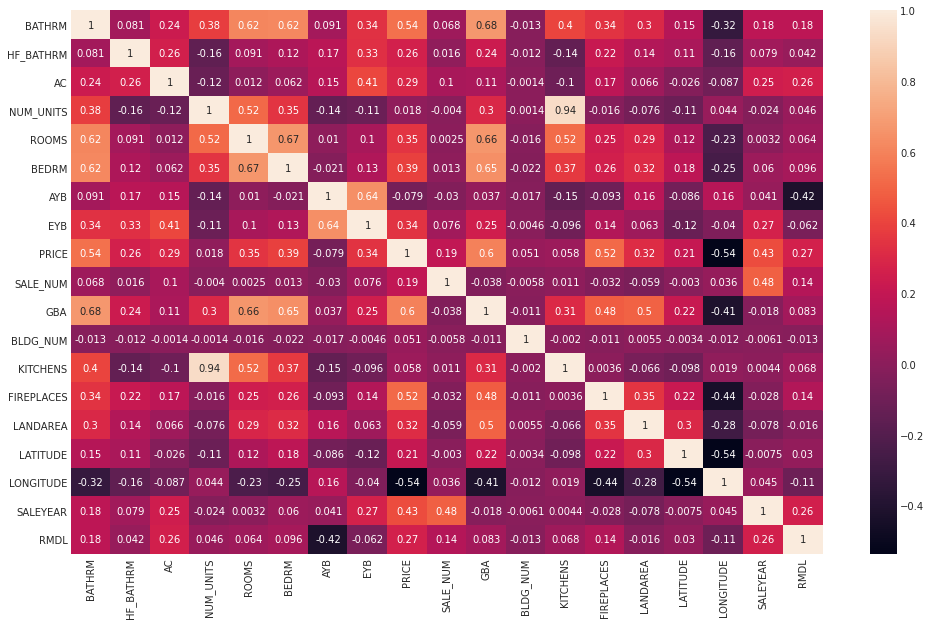

In [51]:
plt.figure(figsize=(15,10))
sns.heatmap(df10.corr(), annot=True)
plt.show()

Some multicollinearity occurs between :
  - NUM_UNITS vs KITCHENS

Weak correlation :
 - BLDG_NUM

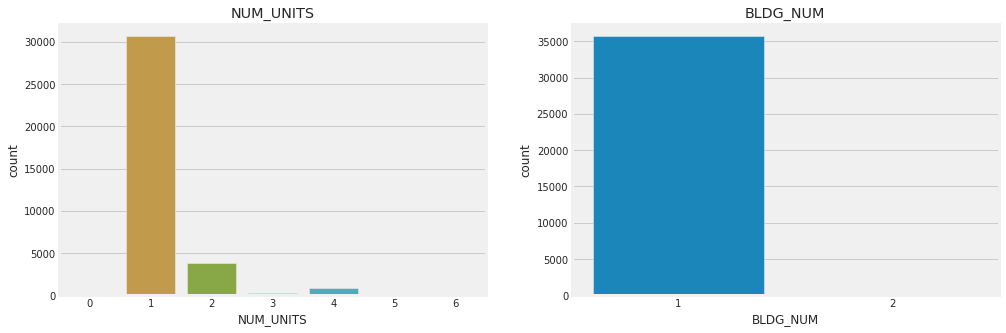

In [52]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(df11['NUM_UNITS'], ax=ax[0]).set_title('NUM_UNITS')
sns.countplot(df11['BLDG_NUM'], ax=ax[1]).set_title('BLDG_NUM')
plt.show()

Since both of the feature has imbalanced values and is not considered important based on our model trial, we decide to drop both features

In [53]:
def drop_correlation(df):
    df = df.drop(['NUM_UNITS','BLDG_NUM'], axis=1)
    
    return df

In [54]:
df12 = drop_correlation(df11)

In [55]:
df12.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'ROOMS', 'BEDRM', 'AYB', 'EYB',
       'PRICE', 'SALE_NUM', 'GBA', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'WARD', 'SALEYEAR', 'RMDL'],
      dtype='object')

In [56]:
df12.shape

(35667, 25)

### 8. FEATURE ENGINEERING

In [57]:
#AYB, EYB change to age, SQFT_ROOMS
def feature_eng(df):
    df['AYB_SALEYEAR_DIFF'] = df['SALEYEAR']-df['AYB']
    df['AYB_SALEYEAR_DIFF'] = df['AYB_SALEYEAR_DIFF'].astype(pd.Int64Dtype())
    
    df['EYB_SALEYEAR_DIFF'] = np.where(df['SALEYEAR']<df['EYB'],0,df['SALEYEAR']-df['EYB'])
    df['EYB_SALEYEAR_DIFF'] = df['EYB_SALEYEAR_DIFF'].astype(pd.Int64Dtype())

    df['SQFT_ROOMS'] = df['GBA']/df['ROOMS']

    df = df.drop(['AYB','EYB'],axis=1)
    return df

In [58]:
#AYB, EYB change to age, SQFT_ROOMS
df13 = feature_eng(df12)

### 9. MODEL EVALUATION

Based on our model evaluation, we drop several features that is insignificant to our model

In [59]:
def drop_model_evaluation(df):
    df = df.drop(['ROOMS','USECODE'],axis=1)

    return df

In [60]:
#drop ROOMS, USECODE
df14 = drop_model_evaluation(df13)

In [61]:
df14.shape

(35667, 24)

### 10. ENCODING

In [62]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.8MB/s 


In [63]:
import category_encoders as ce

In [64]:
#encoding
def encoding_categorical(df):
  ordinal_mapping = [{'col':'CNDTN','mapping':{'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5,'Excellent':6}}]
  ordinal_encoder = ce.OrdinalEncoder(cols ='CNDTN',mapping = ordinal_mapping) 
  df = ordinal_encoder.fit_transform(df)                                                
  return df

In [65]:
df15 = encoding_categorical(df14)                                             

In [66]:
df15.shape

(35667, 24)

In [67]:
df15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35667 entries, 0 to 68478
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BATHRM             35667 non-null  int64  
 1   HF_BATHRM          35667 non-null  int64  
 2   HEAT               35667 non-null  object 
 3   AC                 35667 non-null  int64  
 4   BEDRM              35667 non-null  int64  
 5   PRICE              35667 non-null  float64
 6   SALE_NUM           35667 non-null  int64  
 7   GBA                35667 non-null  float64
 8   STYLE              35667 non-null  object 
 9   STRUCT             35667 non-null  object 
 10  GRADE              35667 non-null  object 
 11  CNDTN              35667 non-null  int64  
 12  EXTWALL            35667 non-null  object 
 13  ROOF               35667 non-null  object 
 14  INTWALL            35667 non-null  object 
 15  KITCHENS           35667 non-null  Int64  
 16  FIREPLACES         356